In [107]:
import matplotlib.pyplot as plt
import numpy as np

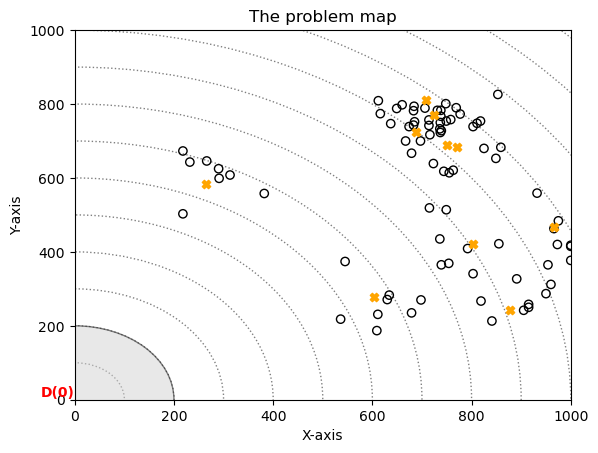

In [237]:
%run Model.ipynb

In [238]:
problems = load_problems("/Users/simonhusebo/Dokumenter/MASTERS CODE/data")

Initial Solution:           [(0, 0), (0, 0), (0, 0), (0, 0), (5, 0), (5, 1), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0), (11, 1), (12, 0), (12, 1), (13, 0), (13, 1), (14, 0), (14, 1), (15, 0), (15, 1), (16, 0), (16, 1), (17, 0), (17, 1), (18, 0), (18, 1), (19, 0), (19, 1), (20, 0), (20, 1)]


<Axes: title={'center': 'The problem map'}, xlabel='X-axis', ylabel='Y-axis'>

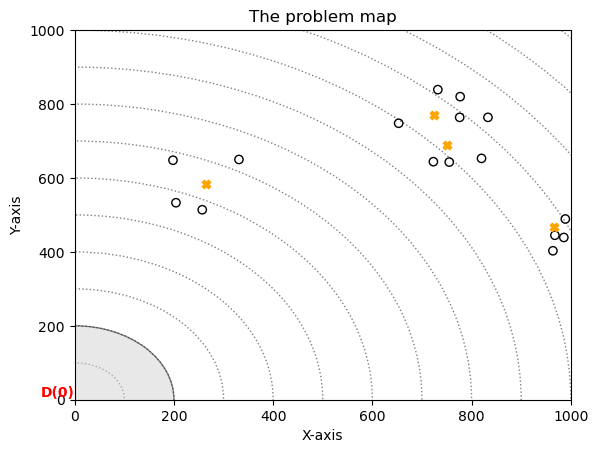

In [239]:
problem = problems[0]
n_trips = problem['N_trips']
initial = initial_solution(problem,n_trips)
operators = [random_remove_greedy_insert,largest_trip_remove_greedy_insert,similarity_removal_greedy_insert]
probabilities = [1/3,1/3,1/3]
show_the_map(problem)

In [224]:
#sol,cost,n_feasible,cost_movement = simple_sim_annealing(inital,problem,operators,probabilities)

In [240]:
best_solution,processed_best,best_cost,best_costs,costs,all_weights,all_scores,all_used,final_improvement,unique,accept_list = ALNS(initial,problem,operators)

New best cost at 0 with cost 167376.64
New best cost at 1 with cost 162129.54
New best cost at 2 with cost 162003.09
New best cost at 3 with cost 151274.37
New best cost at 4 with cost 139022.79
New best cost at 5 with cost 135874.68
New best cost at 9 with cost 130535.22
New best cost at 11 with cost 115861.39
New best cost at 12 with cost 109426.13500000001
New best cost at 13 with cost 104821.195
New best cost at 17 with cost 103694.89000000001
New best cost at 18 with cost 102084.155
New best cost at 24 with cost 99306.95999999999
New best cost at 25 with cost 98476.48
New best cost at 34 with cost 97046.41
New best cost at 78 with cost 91998.81499999999
New best cost at 98 with cost 90366.695
New best cost at 148 with cost 87667.505
New best cost at 590 with cost 87477.67499999999
New best cost at 1345 with cost 87295.97
New best cost at 1366 with cost 85171.435
New best cost at 1368 with cost 84159.785
New best cost at 3074 with cost 82059.11499999999
New best cost at 3078 with c

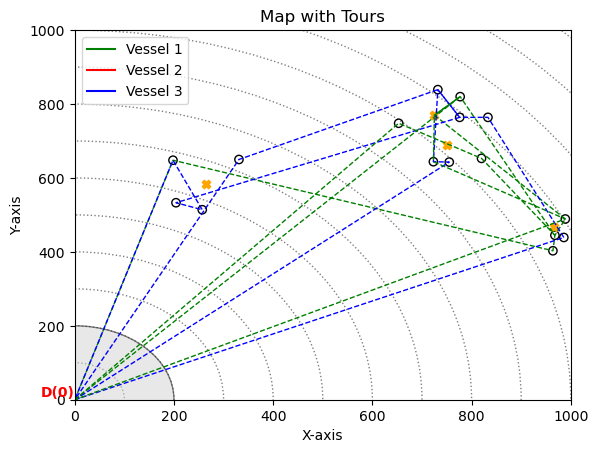

In [241]:
# Create the base map
ax = show_the_map(problem)

# Plot all trips on the map
ax = plot_all_trips(ax, processed_best, problem)

# Display the combined plot
plt.show()

[0, 10, 10, 19, 19, 5, 20, 15, 15, 0]


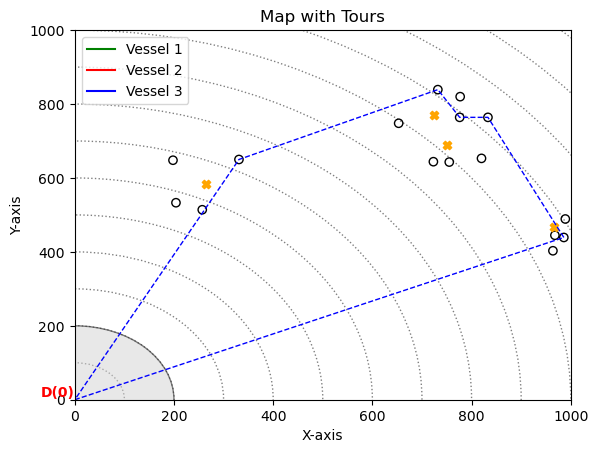

In [242]:
bx = show_the_map(problem)

bx = plot_some_trips(bx, processed_best, problem,1)

plt.show()

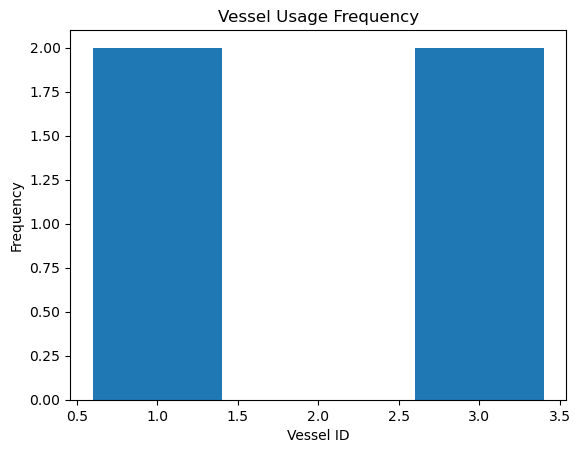

In [243]:
show_vessel_distribution(processed_best)

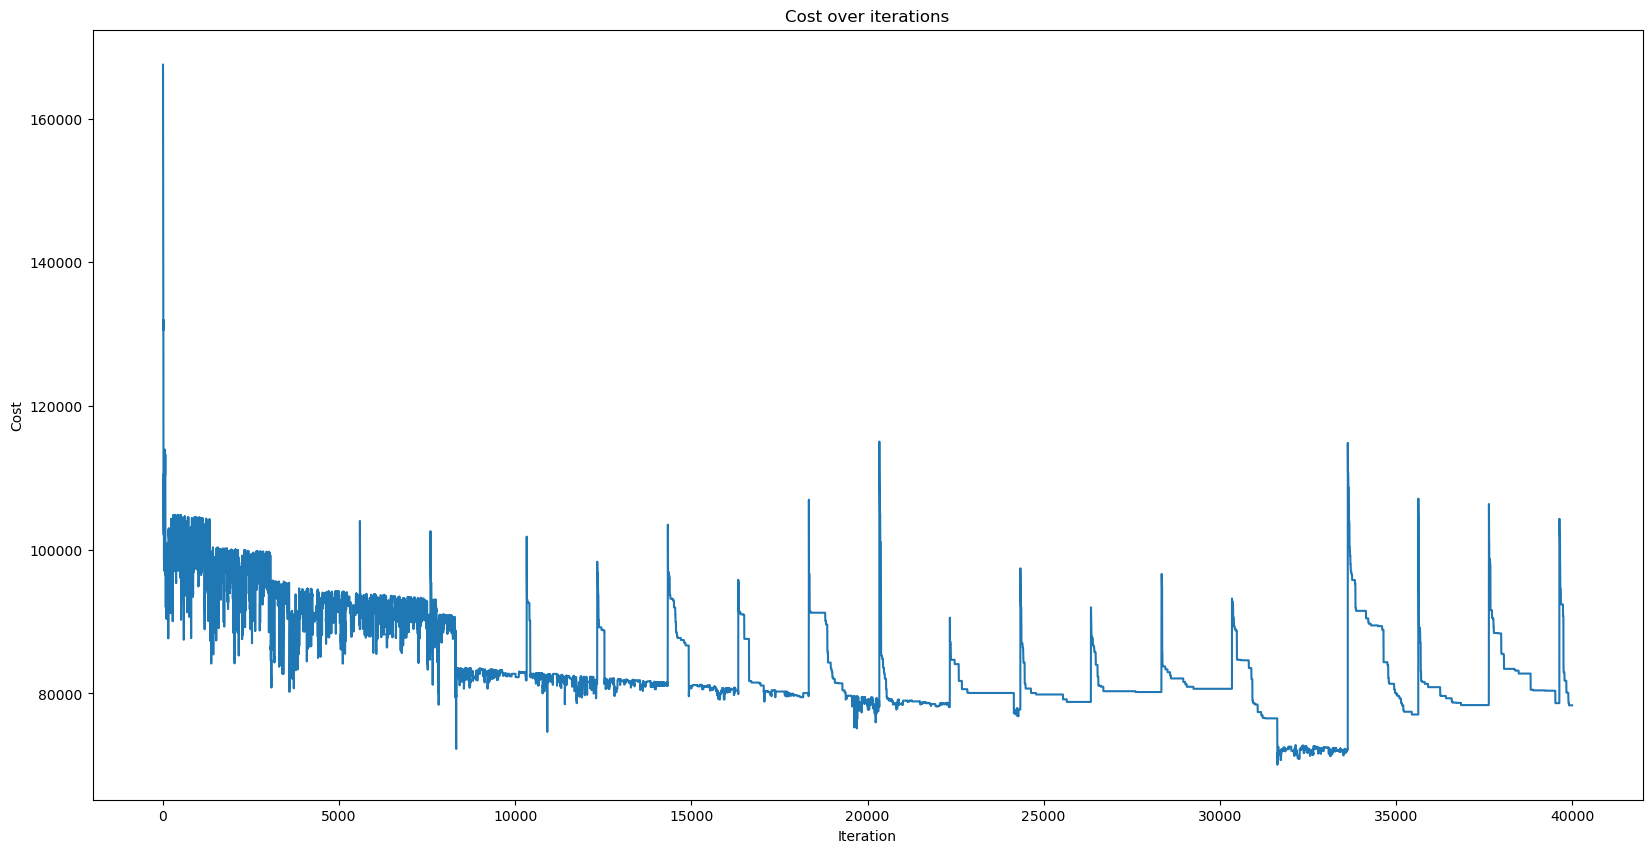

<Axes: title={'center': 'Cost over iterations'}, xlabel='Iteration', ylabel='Cost'>

In [244]:
plot_costs(costs)

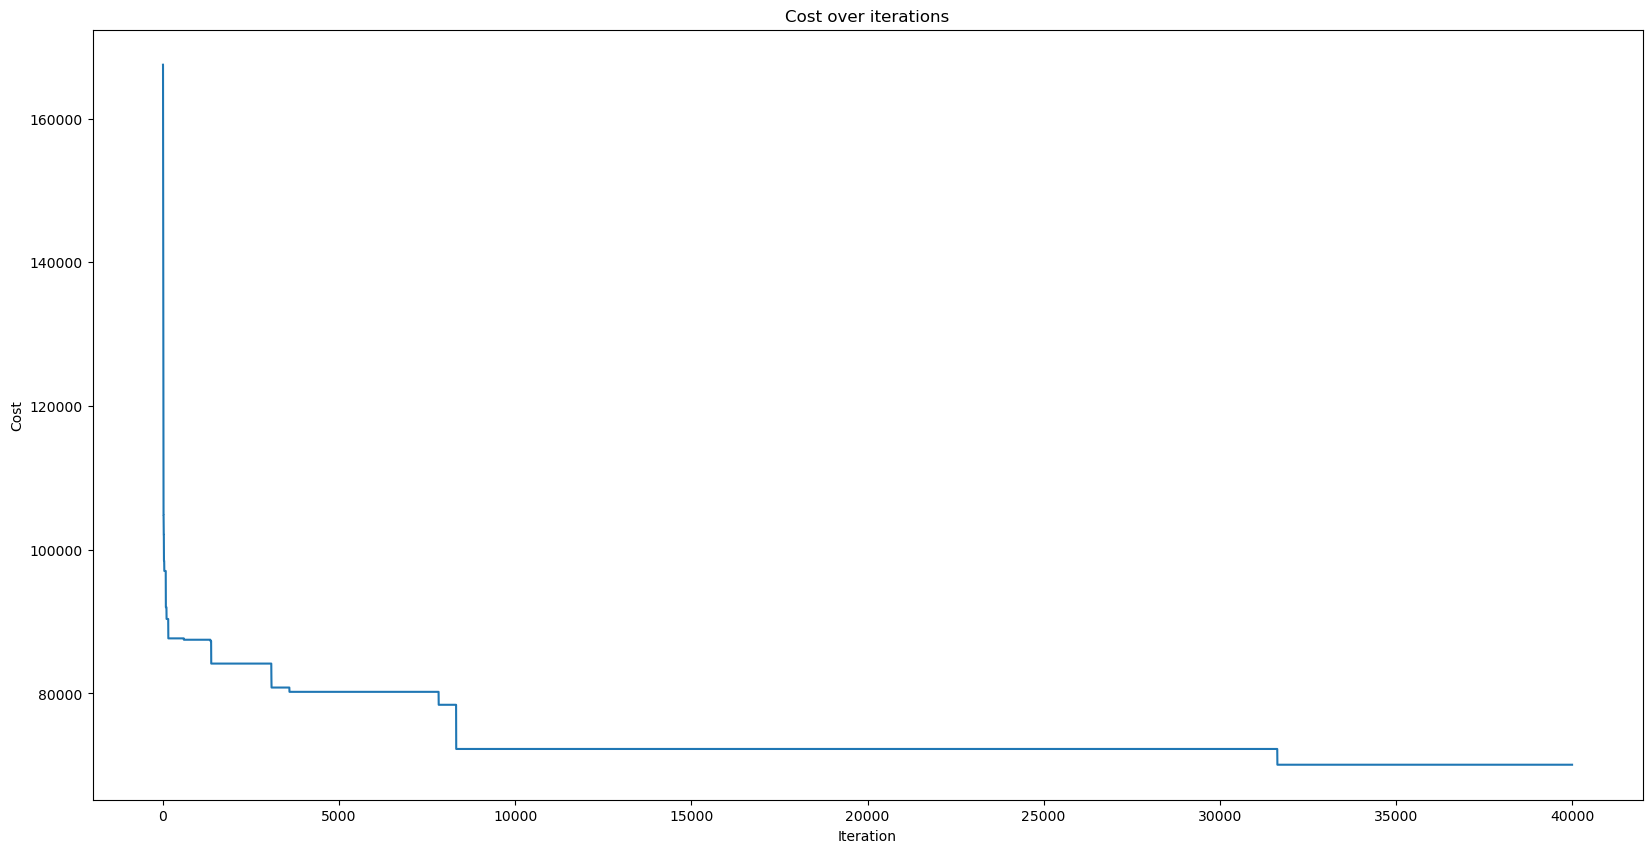

<Axes: title={'center': 'Cost over iterations'}, xlabel='Iteration', ylabel='Cost'>

In [245]:
plot_costs(best_costs)

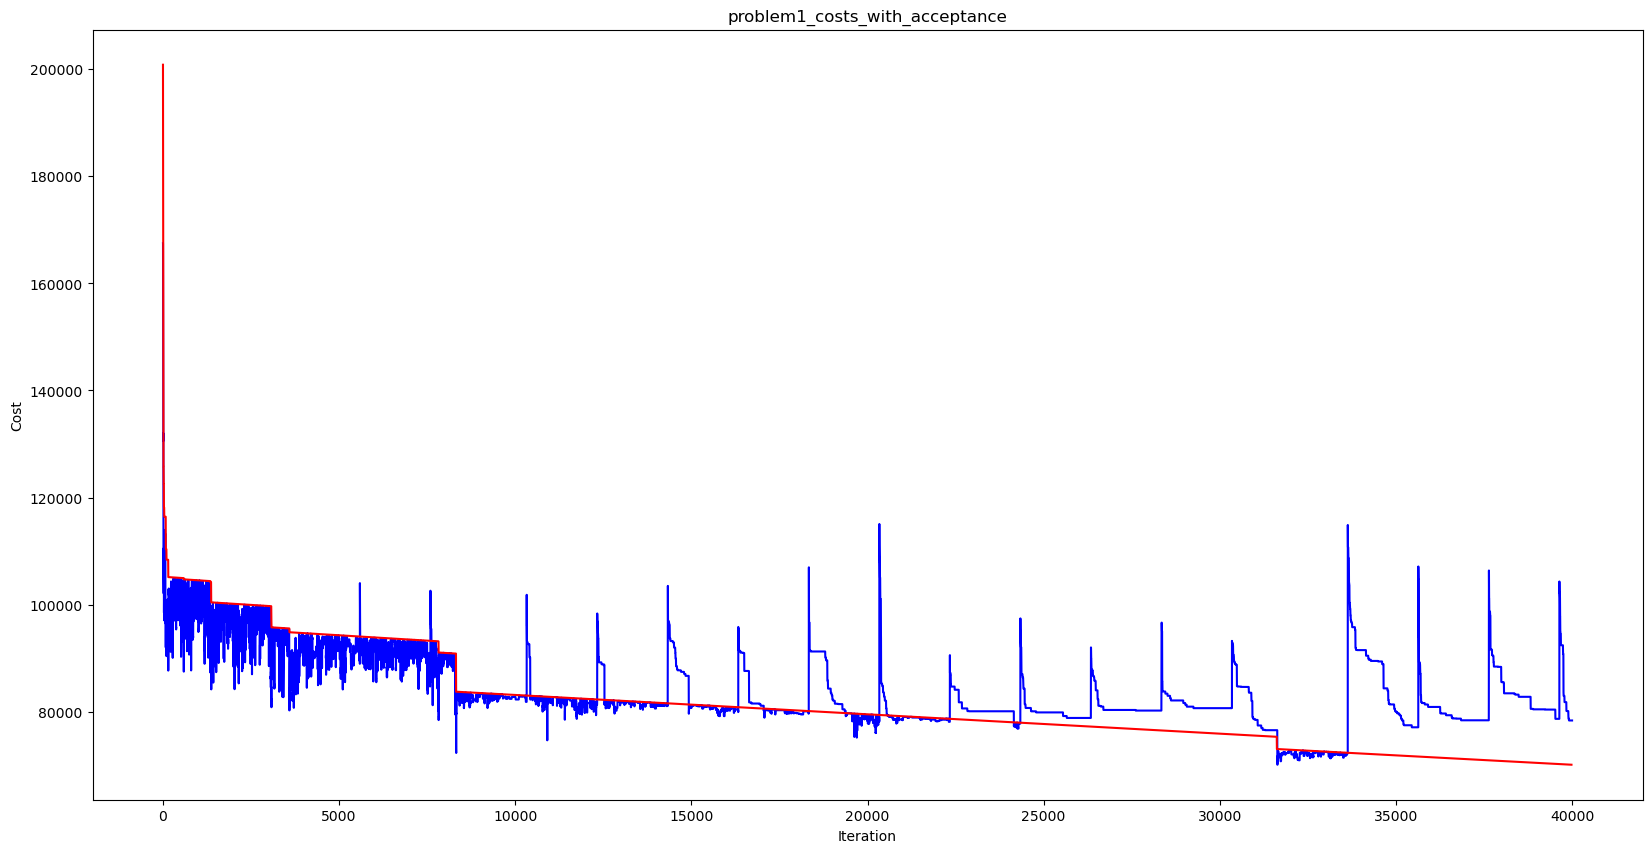

<Axes: title={'center': 'problem1_costs_with_acceptance'}, xlabel='Iteration', ylabel='Cost'>

In [246]:
multiple_plots(costs,accept_list,title='problem1_costs_with_acceptance')

y = -3.29x + 2049683.73


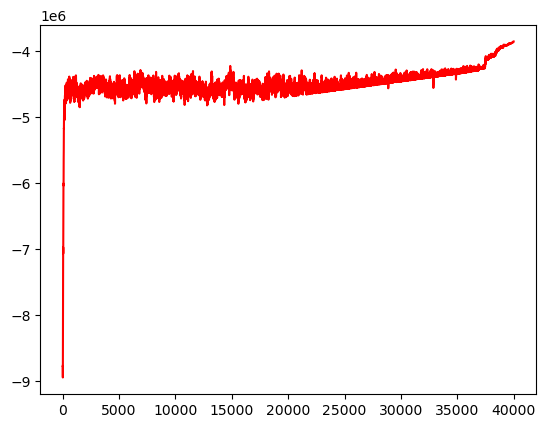

In [172]:
test = costs

coefficients = np.polyfit(range(0,40000), test, 1)
line = np.poly1d(coefficients)
plt.plot(range(0,40000), line(test), 'r-')
# Create the equation string
equation = f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}'
print(equation)

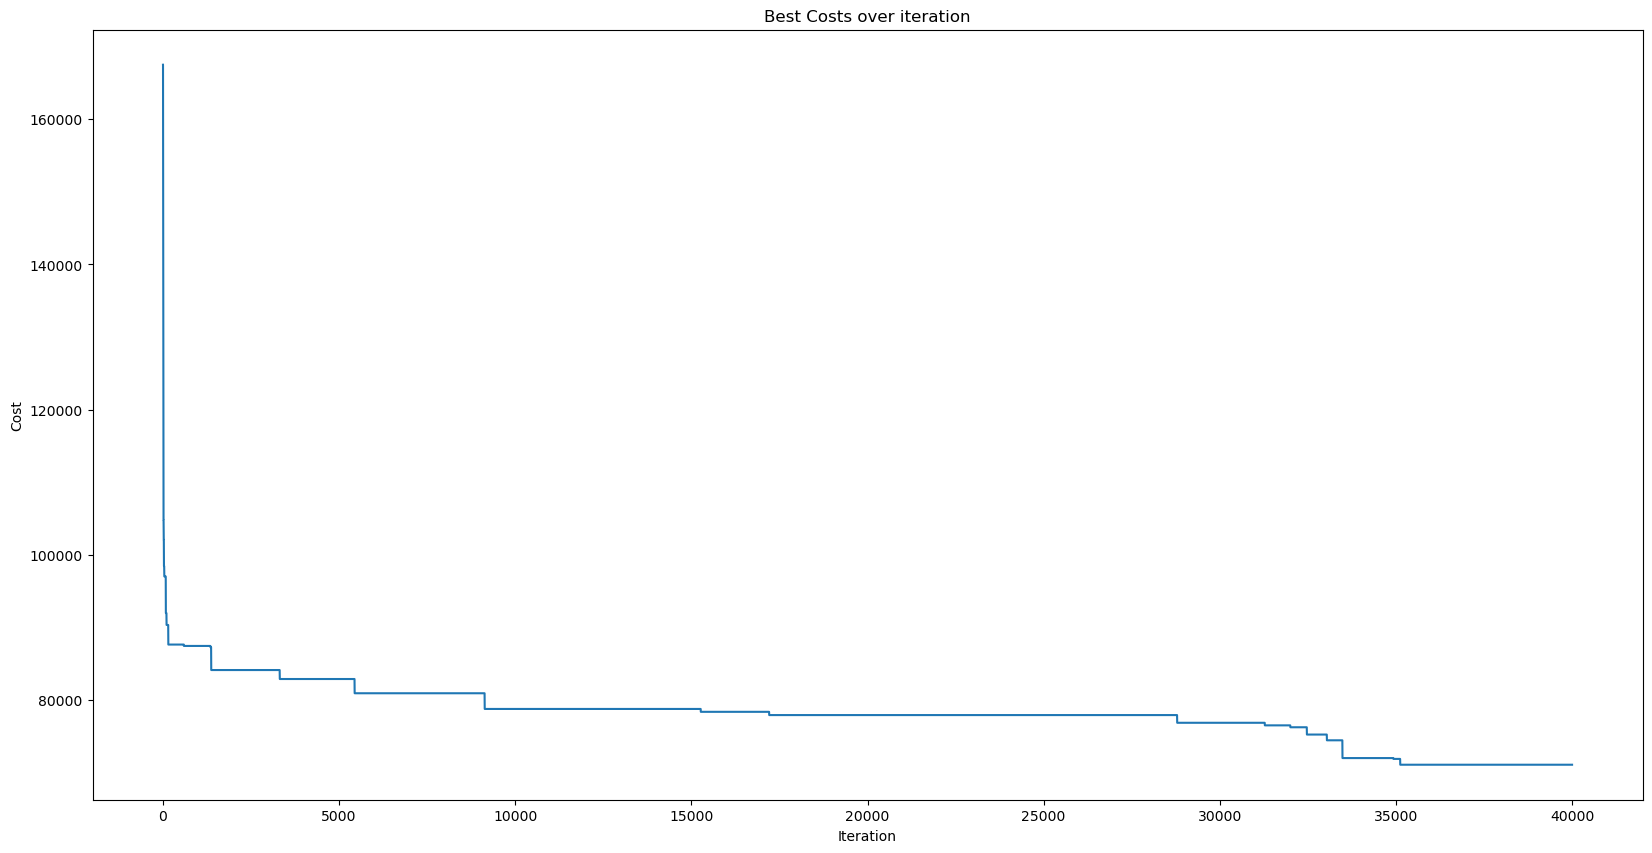

In [127]:
plot_costs(best_costs,title='Best Costs over iteration')

In [119]:
best_solution

[(15, 0),
 (16, 0),
 (15, 1),
 (14, 1),
 (0, 0),
 (20, 0),
 (20, 1),
 (5, 0),
 (5, 1),
 (7, 0),
 (7, 1),
 (6, 0),
 (16, 1),
 (0, 0),
 (18, 0),
 (17, 1),
 (10, 0),
 (11, 1),
 (6, 1),
 (12, 1),
 (0, 0),
 (14, 0),
 (17, 0),
 (19, 0),
 (19, 1),
 (18, 1),
 (8, 0),
 (8, 1),
 (9, 0),
 (11, 0),
 (10, 1),
 (12, 0),
 (9, 1),
 (13, 0),
 (13, 1),
 (0, 0)]

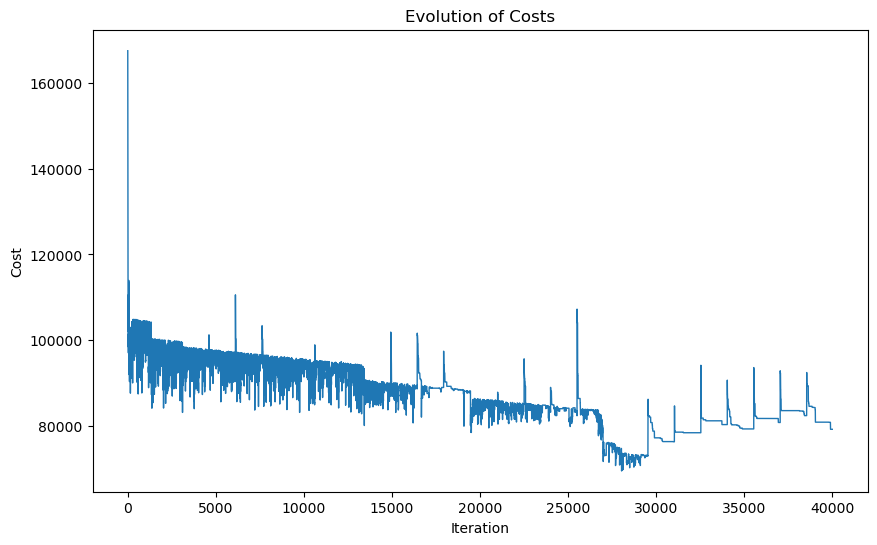

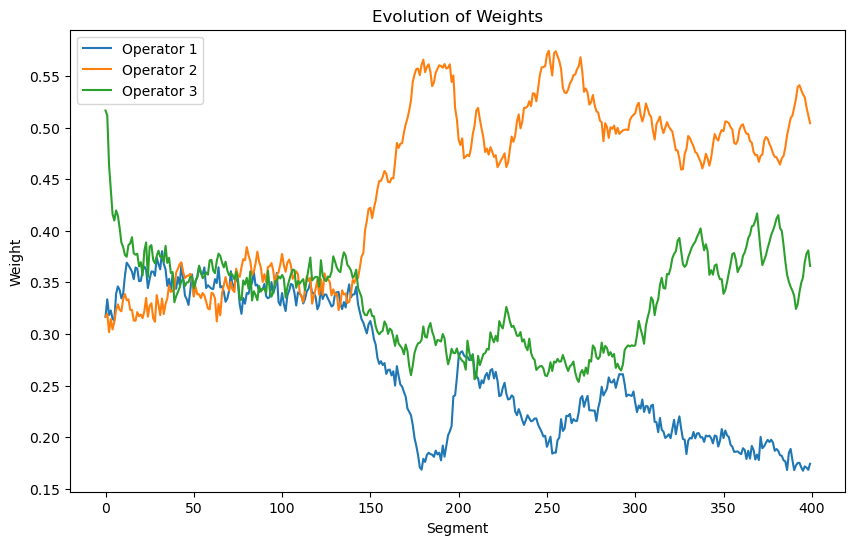

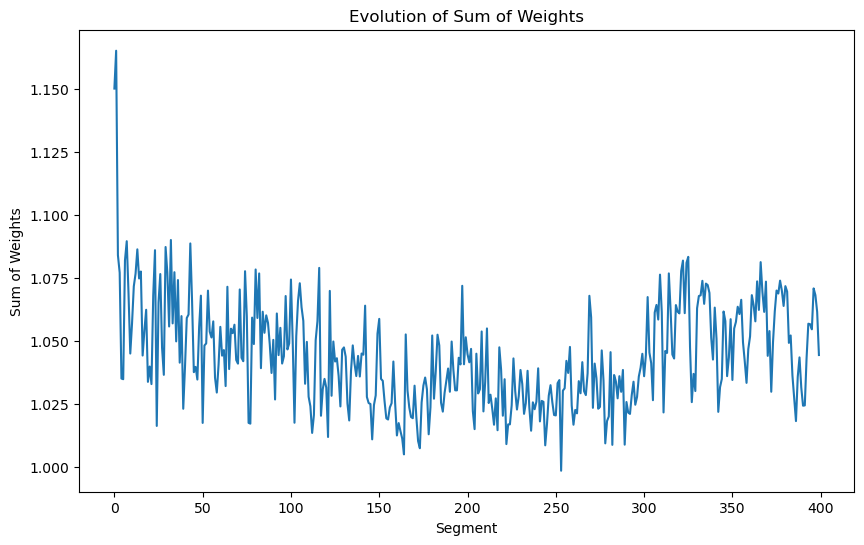

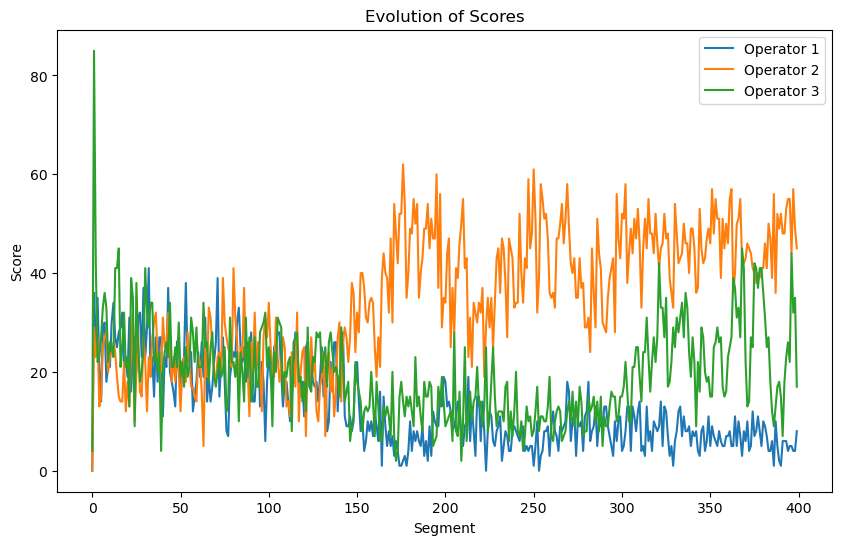

In [120]:
plot_output_lists(costs,all_weights,all_scores)

In [25]:
def multiple_ALNS_runs(initial, problem,operators,n_runs):
    best_solution = initial
    best_cost = objective_function(initial,problem)
    best_costs = []
    cost_lists = []
    improvement_lists = []
    
    for i in range(n_runs):
        print(f'Starting run {i+1}')
        solution,_,cost,improvement,costs,_,_,_,_,_ = ALNS(initial,problem,operators)
        cost_lists.append(costs)
        improvement_lists.append(improvement)
        if cost<best_cost:
            best_solution = solution
            best_cost = cost
            best_costs = costs
    
    
    return best_solution,best_cost,best_costs,cost_lists,improvement_lists

In [4]:
def ExperimentI(problem,trip_range):
    
    charge_lists = []
    n_vessels = []
    best_costs = []
    
    
    operators = [random_remove_greedy_insert,largest_trip_remove_greedy_insert,similarity_removal_greedy_insert]
    
    for i in trip_range:
        print(f'Starting iteration with {i} Vessels')
        inital = initial_solution(problem,n_trips=i)
        _,processed_best,best_cost,_,_,_,_,_,_,_ = ALNS(inital,problem,operators)
        charging = processed_best[2]
        charging_amount = sum(len(sublist) for sublist in charging)
        best_costs.append(best_cost)
        charge_lists.append(charging_amount)
        n_vessels.append(i)
        
    return n_vessels,charge_lists,best_costs

Jobs Information:
Turbine ID      Crew Needed    
9               3              
10              5              
11              1              
12              3              
13              6              
14              6              
15              6              
16              8              
17              3              
18              5              
19              5              
20              3              
21              2              
22              2              
23              4              
24              2              
25              6              
26              7              
27              4              
28              4              
29              8              
30              3              
31              5              
32              5              
33              7              
34              3              
35              5              
36              1              
37              2              
38              1     

<Axes: title={'center': 'The problem map'}, xlabel='X-axis', ylabel='Y-axis'>

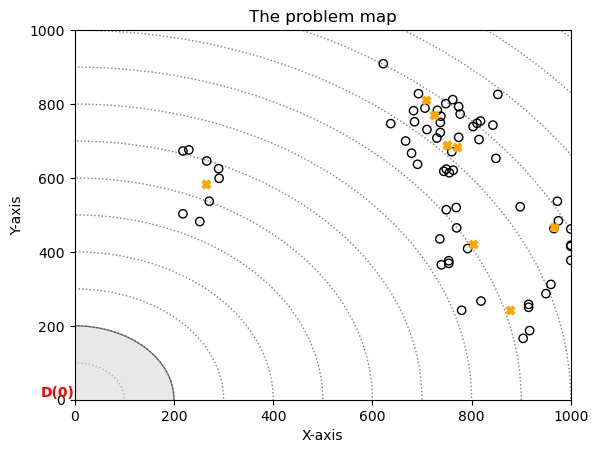

In [20]:
problem = make_problem(n_nodes_per_cluster=8,n_chargers=8)
show_the_map(problem)

In [21]:
n_vessels, chargelist, best_costs = ExperimentI(problem,range(10,31))

Starting iteration with 10 Vessels
Initial Solution:           [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0), (11, 1), (12, 0), (12, 1), (13, 0), (13, 1), (14, 0), (14, 1), (15, 0), (15, 1), (16, 0), (16, 1), (17, 0), (17, 1), (18, 0), (18, 1), (19, 0), (19, 1), (20, 0), (20, 1), (21, 0), (21, 1), (22, 0), (22, 1), (23, 0), (23, 1), (24, 0), (24, 1), (25, 0), (25, 1), (26, 0), (26, 1), (27, 0), (27, 1), (28, 0), (28, 1), (29, 0), (29, 1), (30, 0), (30, 1), (31, 0), (31, 1), (32, 0), (32, 1), (33, 0), (33, 1), (34, 0), (34, 1), (35, 0), (35, 1), (36, 0), (36, 1), (37, 0), (37, 1), (38, 0), (38, 1), (39, 0), (39, 1), (40, 0), (40, 1), (41, 0), (41, 1), (42, 0), (42, 1), (43, 0), (43, 1), (44, 0), (44, 1), (45, 0), (45, 1), (46, 0), (46, 1), (47, 0), (47, 1), (48, 0), (48, 1), (49, 0), (49, 1), (50, 0), (50, 1), (51, 0), (51, 1), (52, 0), (52, 1), (53, 0), (53, 1), (54, 0), (54, 1), (55, 0), (55, 1), (56, 0), (56

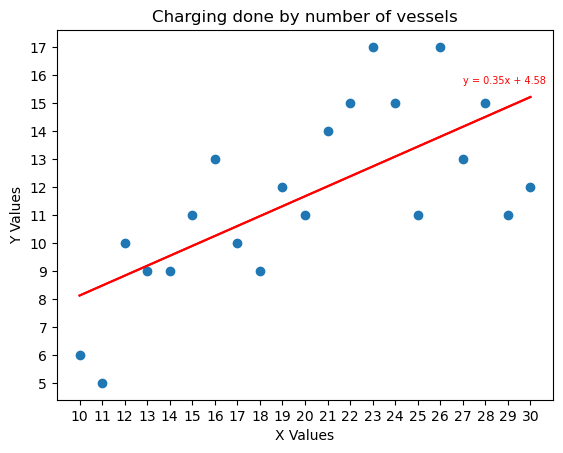

In [46]:


# Create the scatterplot
plt.scatter(n_vessels, chargelist)


# Add labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Charging done by number of vessels')

xticks = np.arange(min(n_vessels), max(n_vessels)+1, step=1)  # change step value as needed
yticks = np.arange(min(chargelist), max(chargelist)+1, step=1)  # change step value as needed
plt.xticks(xticks)
plt.yticks(yticks)

coefficients = np.polyfit(n_vessels, chargelist, 1)
line = np.poly1d(coefficients)
plt.plot(n_vessels, line(n_vessels), 'r-')
# Create the equation string
equation = f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}'

# Add the equation to the plot
plt.text(max(n_vessels)-3, line(max(n_vessels))*1.05, equation, fontsize=7,color = 'red', verticalalignment='top')
plt.plot(n_vessels, line(n_vessels), 'r-')

# Display the plot
plt.show()


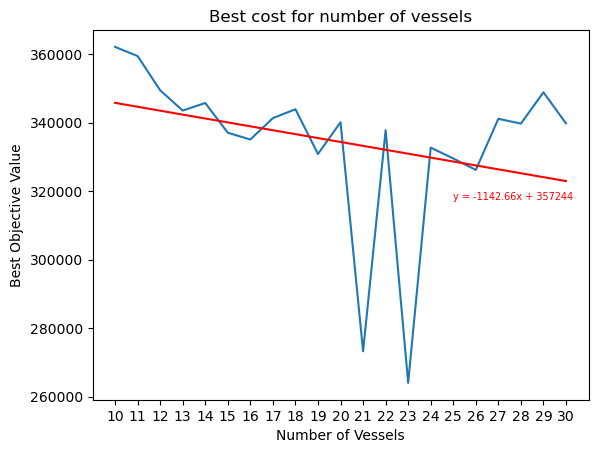

In [45]:
# Create the scatterplot
plt.plot(n_vessels, best_costs)

# Add labels and title
plt.xlabel('Number of Vessels')
plt.ylabel('Best Objective Value')
plt.title('Best cost for number of vessels')

xticks = np.arange(min(n_vessels), max(n_vessels)+1, step=1)  # change step value as needed

plt.xticks(xticks)

coefficients = np.polyfit(n_vessels, best_costs, 1)

line = np.poly1d(coefficients)
# Create the equation string
equation = f'y = {coefficients[0]:.2f}x + {coefficients[1]:.0f}'

# Add the equation to the plot
plt.text(max(n_vessels)-5, line(max(n_vessels))*0.99, equation, fontsize=7,color = 'red', verticalalignment='top')
plt.plot(n_vessels, line(n_vessels), 'r-')

# Display the plot
plt.show()